# TransUNet Inference Demo on Fundus Datasets

This notebook demonstrates how to load the test set, load a trained TransUNet model, run inference on a sample, and visualize the results.

In [1]:
# python -m ipykernel install \
#   --user \
#   --name venv \
#   --display-name "Python (venv)"

In [2]:
# Imports
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random

# Ensure current directory is in python path to handle local imports
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from datasets.dataset_drive import Drive_dataset
    from datasets.dataset_chasedb import ChaseDB_dataset
    from datasets.dataset_hrf import HRF_dataset
    from networks.vit_seg_modeling import VisionTransformer as ViT_seg
    from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
    print("Successfully imported project modules.")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Make sure you are running this notebook from './TransUNet'")

Successfully imported project modules.


/dscilab_hvch_dacloc/workspace/TransUNet/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Configuration
class Args:
    def __init__(self, dataset: str):
        # Dataset Configuration
        self.dataset = dataset
        self.volume_path = "data/" + dataset
        self.num_classes = 2
        self.img_size = 224
        
        # Model Configuration
        self.vit_name = "R50-ViT-B_16" 
        self.n_skip = 3
        self.vit_patches_size = 16
        
        # Checkpoint Path
        # Example: "model/TU_DRIVE224/TU_pretrain_R50-ViT-B_16_skip3_epo150_bs24_224/best_model.pth"
        self.model_path = f"model/TU_{dataset}{self.img_size}/TU_pretrain_{self.vit_name}_skip{self.n_skip}_epo2000_bs16_lr0.005_{self.img_size}/best_model.pth"

args = Args("DRIVE")
print(f"Configuration:\n Dataset: {args.dataset}\n Data Path: {args.volume_path}\n Model Config: {args.vit_name}")

Configuration:
 Dataset: DRIVE
 Data Path: data/DRIVE
 Model Config: R50-ViT-B_16


In [17]:
# Load DRIVE Test Set
try:
    db_test = Drive_dataset(base_dir=args.volume_path, split="test")
    testloader = DataLoader(db_test, batch_size=1, shuffle=False)
    print(f"Test dataset loaded successfully. Total samples: {len(db_test)}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check 'volume_path' and ensure the data exists.")

Test dataset loaded successfully. Total samples: 20


In [18]:
# Initialize Model
def get_model(args):
    config_vit = CONFIGS_ViT_seg[args.vit_name]
    config_vit.n_classes = args.num_classes
    config_vit.n_skip = args.n_skip
    if args.vit_name.find('R50') != -1:
        config_vit.patches.grid = (int(args.img_size / args.vit_patches_size), int(args.img_size / args.vit_patches_size))
    
    net = ViT_seg(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes)
    return net

model = get_model(args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model initialized on {device}.")

# Load Weights
if os.path.exists(args.model_path):
    try:
        model.load_state_dict(torch.load(args.model_path, map_location=device))
        print(f"Loaded weights from {args.model_path}")
    except Exception as e:
        print(f"Error loading weights: {e}")
else:
    print(f"WARNING: Checkpoint not found at {args.model_path}")
    print("Proceeding with random weights for demonstration purposes.")

model.eval()

Model initialized on cuda.
Loaded weights from model/TU_DRIVE224/TU_pretrain_R50-ViT-B_16_skip3_epo2000_bs16_lr0.005_224/best_model.pth


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
        )
        (body): Sequential(
          (block1): Sequential(
            (unit1): PreActBottleneck(
              (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
              (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (relu): ReLU(inplace=True)
              (downsample): StdConv2d(64, 256, 

In [20]:
# Inference and Visualization Function
import tiler

def predict_tiler(model, image, label, classes, tile_size=224, overlap=0.5, batch_size=8):
    image = image.squeeze(0).cpu().detach().numpy() # C, H, W or H, W
    label = label.squeeze(0).cpu().detach().numpy() # H, W
    
    # Check if image is CHW or HW. Tiler expects HWC or HW.
    # If CHW (3, H, W), transpose to HWC.
    if len(image.shape) == 3:
        image = image.transpose(1, 2, 0)
    elif len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
        
    # shape is now (H, W, C)
        
    # Initialize Tiler for image
    img_tiler = tiler.Tiler(
        data_shape=image.shape,
        tile_shape=(tile_size, tile_size, image.shape[-1]),
        overlap=(int(tile_size * overlap), int(tile_size * overlap), 0),
        channel_dimension=2,
        mode='reflect'
    )
    
    # Initialize Tiler for mask (probabilities)
    # We want to store probabilities for each class
    mask_tiler = tiler.Tiler(
        data_shape=(image.shape[0], image.shape[1], classes),
        tile_shape=(tile_size, tile_size, classes),
        overlap=(int(tile_size * overlap), int(tile_size * overlap), 0),
        channel_dimension=2,
        mode='reflect'
    )
    
    # Calculate padding if needed
    new_shape, padding = img_tiler.calculate_padding()
    img_tiler.recalculate(data_shape=new_shape)
    mask_tiler.recalculate(data_shape=new_shape)
    
    padded_img = np.pad(image, padding, mode="reflect")
    
    mask_merger = tiler.Merger(tiler=mask_tiler, window="overlap-tile")
        
    model.eval()
    for batch_id, batch in img_tiler(padded_img, batch_size=batch_size, progress_bar=False):
        # batch is (B, H, W, C)
        # Model expects (B, C, H, W)
        batch_tensor = torch.from_numpy(batch.transpose(0, 3, 1, 2)).float().cuda()
        
        with torch.no_grad():
            outputs = model(batch_tensor)
            probs = torch.softmax(outputs, dim=1) # (B, Classes, H, W)
            
        # Tiler Merger expects (B, H, W, Classes)
        probs_np = probs.cpu().numpy().transpose(0, 2, 3, 1)
        mask_merger.add_batch(batch_id, batch_size, probs_np)
        
    mask_pred_probs = mask_merger.merge(extra_padding=padding, dtype=np.float32)
    # mask_pred_probs is (H, W, Classes)
    
    # Argmax
    prediction = np.argmax(mask_pred_probs, axis=-1)
    return prediction

def visualize_prediction(idx=None, tile=False):
    if idx is None:
        idx = random.randint(0, len(db_test)-1)
    
    print(f"Visualizing sample index: {idx}")
    
    sample = db_test[idx]
    image = sample['image'] # (C, H, W)
    label = sample['label'] # (H, W)
    case_name = sample['case_name']
    
    if not tile:
        input_image = image.unsqueeze(0).to(device) # (1, C, H, W)
        with torch.no_grad():
            output = model(input_image)
            # Apply softmax and get class index
            pred = torch.argmax(torch.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()
    else:
        pred = predict_tiler(model, image, label, classes=2)
        
    # Convert image for display (C, H, W) -> (H, W, C)
    img_vis = image.permute(1, 2, 0).numpy()
    
    # Normalize image for display (min-max normalization)
    if img_vis.max() > img_vis.min():
        img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())
        
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_vis)
    axes[0].set_title(f"Input Image ({case_name})")
    axes[0].axis('off')
    
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Prediction")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [21]:
i = 0

Visualizing sample index: 3


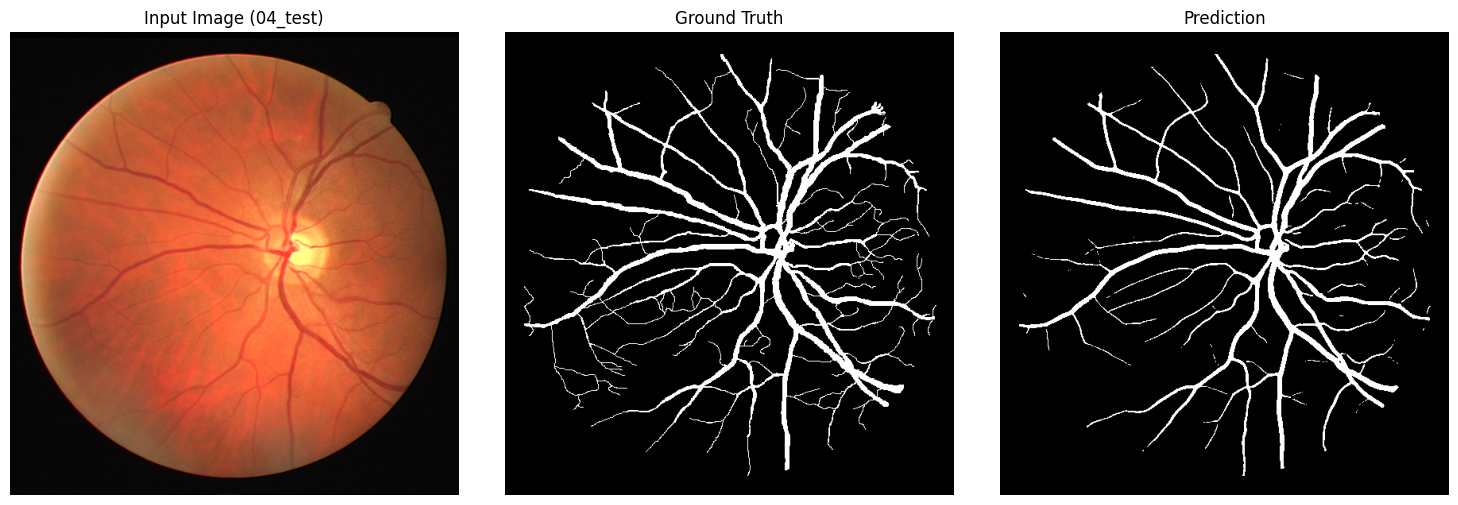

In [27]:
# Run Visualization
if i < len(db_test):
    # visualize_prediction(i, tile=False)
    visualize_prediction(i, tile=True)
    i += 1

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import random
from tiler import Tiler, Merger

def visualize_tiling(db_test, idx=None, tile_size=(224, 224), overlap=0.5):
    """
    Visualizes the tiling process for a sample image from the dataset.
    
    Args:
        db_test: The dataset object (expected to have 'image_paths' attribute).
        idx: Index of the sample to visualize. If None, picks random.
        tile_size: Tuple (H, W) for tile size.
        overlap: Overlap fraction (0.0 to 1.0).
    """
    if Tiler is None:
        print("Cannot run visualization: 'tiler' library is missing.")
        return

    if idx is None:
        idx = random.randint(0, len(db_test)-1)
    
    # Access image_paths from the dataset object
    if hasattr(db_test, 'image_paths'):
        img_path = db_test.image_paths[idx]
        image = io.imread(img_path)
    else:
        print("Error: db_test object does not have 'image_paths' attribute.")
        return
    
    print(f"Visualizing tiling for sample {idx}")
    print(f"Image Path: {img_path}")
    print(f"Original Image Shape: {image.shape}")
    
    # Handle dimensions for Tiler
    is_gray = False
    if len(image.shape) == 2:
        data_shape = image.shape + (1,)
        tile_shape = tile_size + (1,)
        check_image = image[..., np.newaxis]
        is_gray = True
    elif len(image.shape) == 3:
        data_shape = image.shape
        tile_shape = tile_size + (image.shape[2],)
        check_image = image
        is_gray = False
    else:
        print(f"Image shape {image.shape} not supported for this demo.")
        return

    # Initialize Tiler
    # channel_dimension=2 implies HWC format
    tiler = Tiler(
        data_shape=data_shape,
        tile_shape=tile_shape,
        overlap=overlap,
        channel_dimension=2
    )
    
    print(f"Tiler configured. Number of tiles: {len(tiler)}")
    
    # Collect tiles
    tiles = []
    for tile_id, tile in tiler.iterate(check_image):
        tiles.append(tile)
        
    # Merge tiles back to check reconstruction
    merger = Merger(tiler)
    for tile_id, tile in tiler.iterate(check_image):
        merger.add(tile_id, tile)
    
    merged_image = merger.merge(unpad=True)
    
    # Cast merged image to match original dtype if needed
    if merged_image.dtype != image.dtype:
        merged_image = merged_image.astype(image.dtype)
        
    # Calculate reconstruction difference
    diff = np.abs(check_image.astype(np.float32) - merged_image.astype(np.float32)).mean()
    print(f"Reconstruction Difference (Mean Abs): {diff}")
    
    # Visualization
    # 1. Plot Original Image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray' if is_gray else None)
    plt.title(f"Original Image (Shape: {image.shape})")
    plt.axis('off')
    plt.show()

    # 2. Plot All Tiles in a Grid
    n_tiles = len(tiles)
    cols = 5  # Number of columns for the grid
    rows = (n_tiles + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(f"All {n_tiles} Tiles (Size: {tile_size}, Overlap: {overlap})", fontsize=16)
    
    axes = axes.flatten()
    for i in range(len(axes)):
        if i < n_tiles:
            t = tiles[i]
            if is_gray: t = np.squeeze(t)
            axes[i].imshow(t, cmap='gray' if is_gray else None)
            # axes[i].set_title(f"Tile {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # 3. Plot Merged Image
    plt.figure(figsize=(10, 10))
    m_img = merged_image
    if is_gray: m_img = np.squeeze(m_img)
    plt.imshow(m_img, cmap='gray' if is_gray else None)
    plt.title(f"Merged Image (Diff: {diff:.6f})")
    plt.axis('off')
    plt.show()

Visualizing tiling for sample 0
Image Path: data/DRIVE/images/01_test.tif
Original Image Shape: (584, 565, 3)
Tiler configured. Number of tiles: 25
Reconstruction Difference (Mean Abs): 0.0


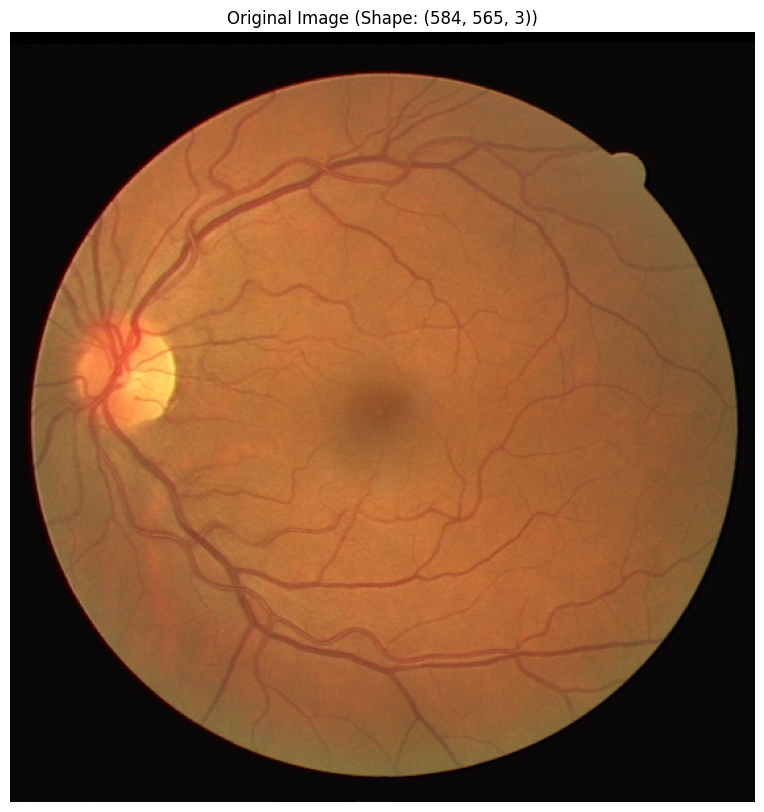

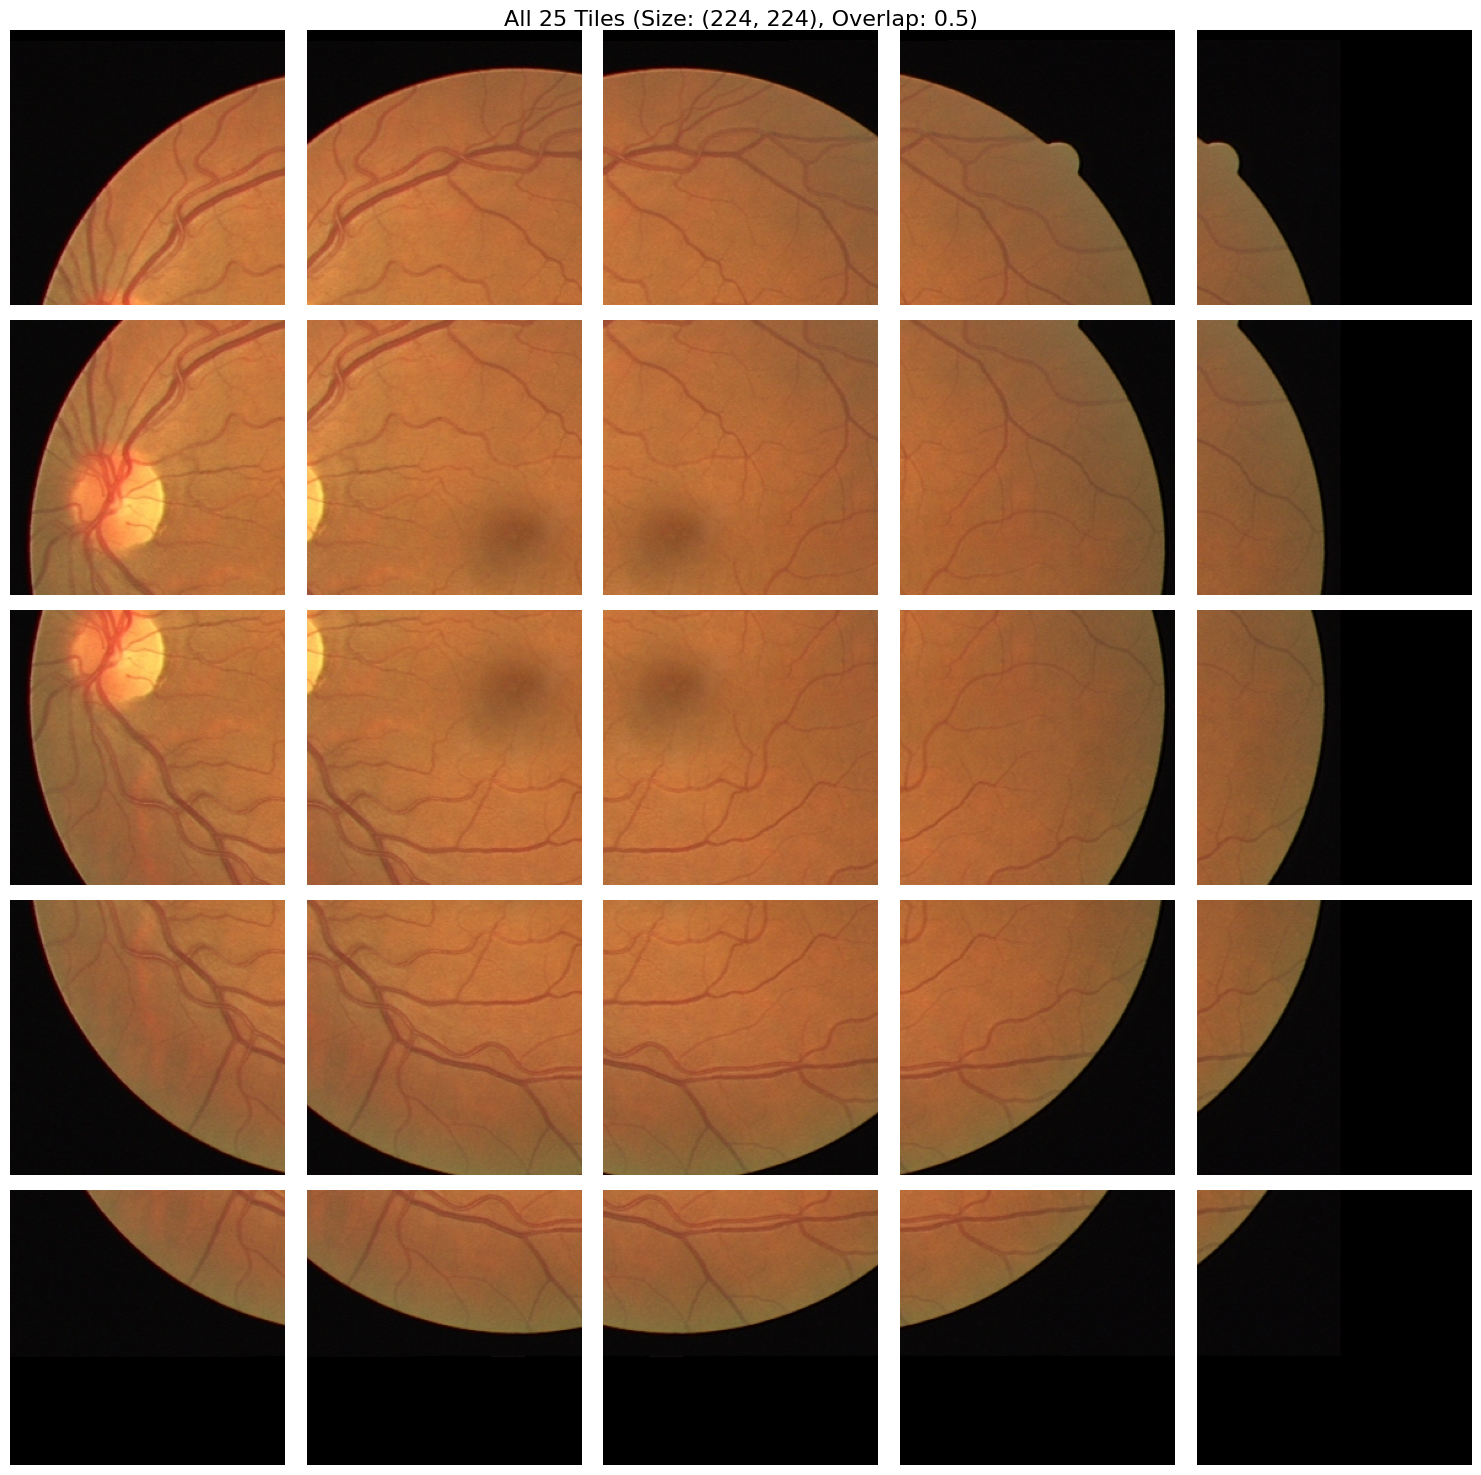

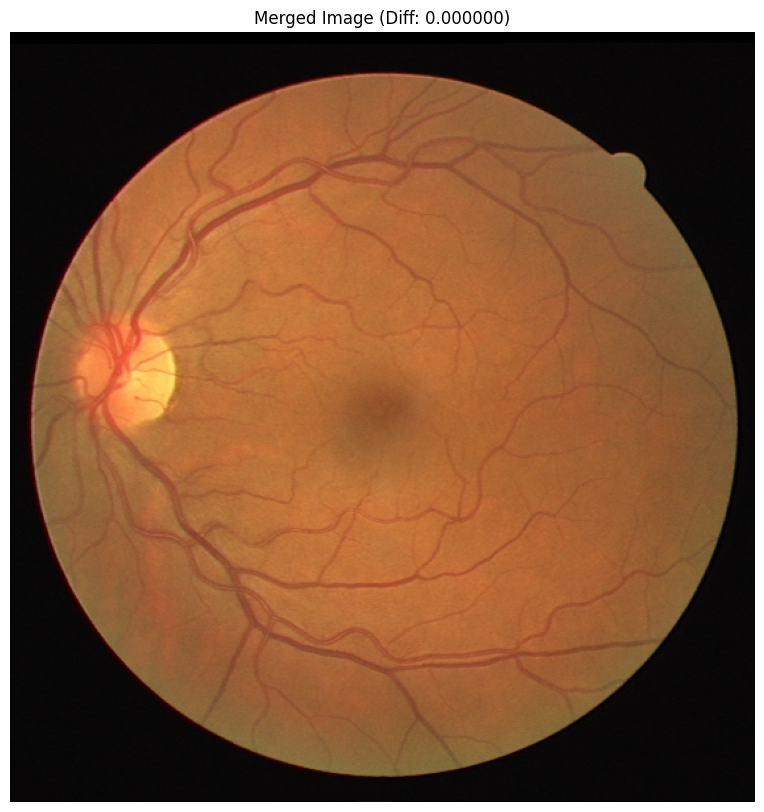

In [25]:
visualize_tiling(db_test, idx=0)